In [1]:
!pip install -q timm
!pip install -q editdistance

In [2]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import editdistance
import pandas as pd
import numpy as np
import json
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
import timm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split
import cv2
import os
import random
import math
import wandb
import string
import gc
import sys

def seed_everything(seed:int=42) -> None:
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [174]:
class config:
    seed = 42
    batch_size = 64
    num_workers = 4
    pin_memory = True
    size = 512, 128
    epochs = 25
    device = "cuda"
    max_length = 25
    
seed_everything(config.seed)

In [4]:
with open("../input/nto-ocr/data/train/labels.json") as f:
    labels1 = json.loads(f.read())
    
pathes1 = [os.path.join("../input/nto-ocr/data/train/images", filename) for filename in list(labels1.keys())]
labels1 = list(labels1.values())

pathes_labels_df2 = pd.read_csv("../input/cyrillic-handwriting-dataset/train.tsv", on_bad_lines='skip', sep="\t", names=["filenames", "text"])

pathes2 = pathes_labels_df2["filenames"].apply(lambda _: os.path.join("../input/cyrillic-handwriting-dataset/train", _)).to_numpy()
labels2 = pathes_labels_df2["text"].to_numpy()

pathes_labels_df3 = pd.read_csv("../input/cyrillic-handwriting-dataset/test.tsv", on_bad_lines='skip', sep="\t", names=["filenames", "text"])

pathes3 = pathes_labels_df3["filenames"].apply(lambda _: os.path.join("../input/cyrillic-handwriting-dataset/test", _)).to_numpy()
labels3 = pathes_labels_df3["text"].to_numpy()

pathes = np.concatenate([pathes1, pathes2, pathes3], axis=0)
labels = np.concatenate([labels1, labels2, pathes3], axis=0)

outliers = np.array([list(labels).index(label) for label in labels if len(label) > config.max_length])

pathes = np.delete(pathes, outliers)
labels = np.delete(labels, outliers)

del pathes1, pathes2, pathes3
del labels1, labels2, labels3
del pathes_labels_df2, pathes_labels_df3
gc.collect()

60

In [5]:
test_size = 0.2
train_pathes, validation_pathes, train_labels, validation_labels = train_test_split(pathes, labels, random_state=config.seed, shuffle=True, test_size=test_size)

In [6]:
class Dataset:
    russian_lower_letters = list("абвгдеёжзийклмнопрстуфхцчшщъыьэюя")
    russian_upper_letters = list("АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯ")
    english_lower_letters = list(string.ascii_lowercase)
    english_upper_letters = list(string.ascii_uppercase)
    digits = list(string.digits)
    puntuations = list(string.punctuation + " ")
    special_tokens = ["<PAD>", "<BOS>", "<OOV>", "<EOS>"]
    characters = special_tokens[:-1] + russian_lower_letters + russian_upper_letters + digits + puntuations + ["<EOS>"]
    classes = {idx: character for idx, character in enumerate(characters)}
    reversed_classes = {character: idx for idx, character in enumerate(characters)}
    
    oov_token_index = reversed_classes["<OOV>"]
    bos_token_index = reversed_classes["<BOS>"]
    pad_token_index = reversed_classes["<PAD>"]
    eos_token_index = reversed_classes["<EOS>"]
    
    def __init__(self, pathes, labels=None, transforms=None, max_length=25, add_special_tokens=False):
        self.pathes = pathes
        self.labels = labels
        self.transforms = transforms
        self.max_length = max_length
        self.add_special_tokens = add_special_tokens
        self.reversed_classes = {class_: idx for idx, class_ in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.pathes)
    
    @staticmethod
    def text2label(text):
        label = []
        for _ in list(text):
            encoded = Dataset.reversed_classes.get(str(_), Dataset.oov_token_index)
            label.append(encoded)
            
        label = np.array(label)
        return label
    
    @staticmethod
    def label2text(label):
        text = []
        for _ in label:
            decoded = Dataset.classes.get(int(_), Dataset.classes[Dataset.oov_token_index])
    
            if decoded not in Dataset.special_tokens:
                text.append(decoded)
        
        text = "".join(text)
        return text
    
    
    @staticmethod
    def labels2texts(labels):
        texts = []
        for label in labels:
            text = Dataset.label2text(label)
            texts.append(text)
        
        texts = np.array(texts)
        return texts
    
    @staticmethod
    def texts2labels(texts):
        labels = []
        for text in texts:
            label = list(Dataset.text2label(text))
            labels.append(label)
        
        labels = np.array(labels)
        return labels
    
    @staticmethod
    def pad_label(label, max_length, pad_token_index):
        label = list(label)
        length = len(label)
        assert max_length >= length, f"'max_length' must be equal or greater than input sequence's length, but input sequence's length ({length}) > max length ({max_length})"
        num_paddings = max_length - length
        padded_label = label + ([pad_token_index] * num_paddings)
        padded_label = np.array(padded_label)
        
        return padded_label
    
    @staticmethod
    def add_special_tokens(label, bos_token_index, eos_token_index):
        label = list(label)
        added_label =  [bos_token_index] + label + [eos_token_index]
        added_label = np.array(added_label)
        return added_label
    
    
    def show_samples(self, rows=1, columns=1, coef=3):
        figsize = (rows*coef, columns*coef) if rows >= columns else (columns*coef, rows*coef)
        fig = plt.figure(figsize=figsize)
        fig.set_facecolor("#fff")
        
        num_samples = len(self)
        for i in range(rows*columns):
            index = random.randint(0, num_samples-1)
            image, label = self[index]
            image = image.permute(1, 2, 0)
            label = Dataset.label2text(label)
            
            ax = fig.add_subplot(rows, columns, i+1)
            ax.set_facecolor("#fff")
            ax.imshow(image)
            ax.set_title(label)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        
        fig.tight_layout(pad=1)
        fig.show()
        
    
    def __getitem__(self, index):
        path = self.pathes[index]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = np.expand_dims(image,axis=-1)
        
        if self.transforms:
            image = self.transforms(image=image)["image"]
        
        if self.labels is not None:
            label = self.labels[index]
            label = Dataset.text2label(label)            
            if self.add_special_tokens:
                label = Dataset.add_special_tokens(label, bos_token_index=Dataset.bos_token_index, eos_token_index=Dataset.eos_token_index)
                
            label = Dataset.pad_label(label, max_length=self.max_length+2, pad_token_index=Dataset.pad_token_index)
            
            return image, label
        
        return image
    
    def get_classes_frequency(self, return_encoded=False):
        all_ = "".join(self.labels)
        
        unique, counts = np.unique(list(all_), return_counts=True)
        frequency = counts / len(all_)
        encoded_keys = Dataset.texts2labels(unique).squeeze(axis=1)
    
        if return_encoded:
            return dict(zip(unique, frequency)), dict(zip(encoded_keys, frequency))
        
        return dict(zip(unique, frequency))
    
    @staticmethod
    def create_loader(pathes, labels=None, transforms=None, max_length=25, add_special_tokens=False, batch_size=16, pin_memory=False, num_workers=0, shuffle=False, drop_last=False):
        dataset = Dataset(pathes=pathes, 
                          labels=labels, 
                          max_length=max_length,
                          transforms=transforms, 
                          add_special_tokens=add_special_tokens)
        
        loader = DataLoader(dataset=dataset, 
                            batch_size=batch_size, 
                            pin_memory=pin_memory, 
                            num_workers=num_workers, 
                            shuffle=shuffle, 
                            drop_last=drop_last)
        
        return dataset, loader
    
    @staticmethod
    def collate_batch(batch, inputs_device="cpu", labels_device="cpu"):
        if len(batch) > 1:
            inputs, labels = batch
            inputs = inputs.to(inputs_device).float()
            labels = labels.to(labels_device).float()
            
            return inputs, labels
        else:
            return batch.to(inputs_device)

In [7]:
train_transforms = A.Compose([
    A.Resize(*config.size[::-1]),
    A.Blur(blur_limit=4, p=0.2),
    A.Perspective(scale=(0.025, 0.075), p=0.1),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.05, rotate_limit=[-3, 3], p=0.2),
    A.RandomBrightness(limit=0.15, p=0.2),
    A.RandomContrast(limit=0.15, p=0.2),
    A.CLAHE(p=0.2),
    A.Cutout(num_holes=10, max_h_size=4, max_w_size=4, fill_value=0, p=0.1),
    A.Downscale(scale_min=0.9, scale_max=0.99,p=0.1),
    A.Equalize(p=0.2),
    A.Sharpen(alpha=(0.1, 0.4), lightness=(0.75, 1.0), p=0.2),
    A.Normalize(),
    ToTensorV2(),
])


train_dataset, train_loader = Dataset.create_loader(pathes=train_pathes, 
                                                    labels=train_labels, 
                                                    transforms=train_transforms,
                                                    add_special_tokens=True,
                                                    max_length=config.max_length,
                                                    batch_size=config.batch_size, 
                                                    pin_memory=config.pin_memory, 
                                                    num_workers=config.num_workers, 
                                                    shuffle=True, 
                                                    drop_last=False)


validation_transforms = A.Compose([
    A.Resize(*config.size[::-1]),
    A.Normalize(mean=0, std=1),
    ToTensorV2(),
])

validation_dataset, validation_loader = Dataset.create_loader(pathes=validation_pathes, 
                                                              labels=validation_labels, 
                                                              transforms=validation_transforms,
                                                              add_special_tokens=True,
                                                              max_length=config.max_length,
                                                              batch_size=config.batch_size*2, 
                                                              pin_memory=not config.pin_memory, 
                                                              num_workers=config.num_workers, 
                                                              shuffle=False, 
                                                              drop_last=False)

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_ch

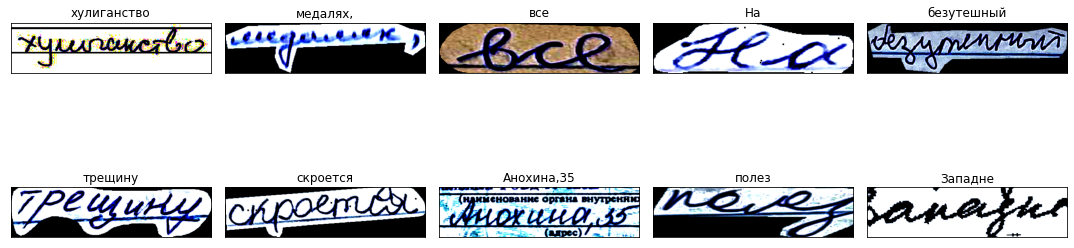

In [8]:
train_dataset.show_samples(rows=2, columns=5)

In [9]:
class Evaluator:
    def __init__(self, model, loss, num_classes, device="cpu"):
        self.model = model
        self.loss = loss
        self.device = device
        self.num_classes = num_classes
    
    def __call__(self, loader):
        loss = 0
        
        self.model.eval()
        self.model.to(self.device)
        with torch.no_grad():
            for batch in loader:
                batch_inputs, batch_labels = Dataset.collate_batch(batch, inputs_device=self.device, labels_device=self.device)
            
                batch_outputs = self.model(batch_inputs, batch_labels[:, :-1]).contiguous()
                batch_outputs_ = batch_outputs.view(-1, self.num_classes).float()
                batch_labels_ = batch_labels[:, 1:].contiguous().view(-1).long()

                batch_loss = self.loss(batch_outputs_, batch_labels_)
                loss += batch_loss
                
            loss /= len(loader)
            
        return loss

In [175]:
class CER:
    def __init__(self, eps=1e-7):
        """
        eps:int - small value for avoiding divising by zero in denominator. default: 1e-7
        """
        
        self.eps = eps
        
    def __call__(self, predictions, targets):        
        assert len(predictions) == len(targets)
        
        distances = []
        lengths = []
        for prediction, target in zip(predictions, targets):
            distance = editdistance.eval(prediction, target)
            distances.append(distance)
            lengths.append(len(target))
            
        cer = (sum(distances) / (sum(lengths) + self.eps)) * 100
        return cer

class Accuracy:
    def __init__(self):
        pass
    
    def __call__(self, predictions, targets):
        assert (len(predictions) == len(targets)) and (len(predictions) > 0)
        
        predictions = np.array(predictions)
        targets = np.array(targets)                   

        corrects = sum(predictions == targets)
        n = len(predictions)
        
        return corrects / n

In [176]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    

class MapToSequence(nn.Module):
    def __init__(self, in_features=7, out_features=10, batch_first=False):
        super(MapToSequence, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.LeakyReLU(),
        )
        
        self.batch_first = batch_first
        
    def forward(self, x):
        b, c, h, w = x.size()
        assert h == 1, f"Height must be equal 1, but got {h}"
        x = x.squeeze(dim=2)
        o = self.layers(x)
        
        if self.batch_first:
            o = o.permute(0, 2, 1)
        else:
            o = o.permute(2, 0, 1)
        
        return o

    
class HeadAttention(nn.Module):
    def __init__(self, embedding_dim=768):
        super(HeadAttention, self).__init__()
        self.S = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=embedding_dim),
            nn.LeakyReLU(),
            nn.Linear(in_features=embedding_dim, out_features=embedding_dim),
        )
        self.tanh = nn.Tanh()
        
        self.W = nn.Linear(in_features=embedding_dim, out_features=1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, features):
        scores = self.tanh(self.S(features)) # torch.Size([batch_size, max_length, hidden_state])
        attention_weights = self.softmax(self.W(scores)) # torch.Size([batch_size, max_length, 1])
        context_vector = features * attention_weights # t# torch.Size([batch_size, max_length, hidden_state])
        return context_vector
    

class Encoder(nn.Module):
    def __init__(self, encoder_name="resnet34", sequence_length=26, encoder_output_width=7, encoder_output_channels=512, pretrained=True, in_channels=3, batch_first=False, embeddings_index=-1):
        super(Encoder, self).__init__()
        self.feature_extractor = timm.create_model(encoder_name, pretrained=pretrained, in_chans=in_channels, features_only=True)
        self.max_pool = nn.MaxPool2d(kernel_size=(4, 1), stride=2)
        self.map_to_sequence = MapToSequence(in_features=encoder_output_width, out_features=sequence_length, batch_first=batch_first)
        self.attention = HeadAttention(embedding_dim=encoder_output_channels)
        
        self.embeddings_index = embeddings_index
        self.batch_first = batch_first
        
    def forward(self, x):
        output = self.feature_extractor(x)[self.embeddings_index]
        output = self.max_pool(output)

        output = self.map_to_sequence(output)
        output = self.attention(output)
        
        return output
    

class Decoder(nn.Module):
    def __init__(self, d_model=512, num_classes=26, batch_first=False):
        super(Decoder, self).__init__()
        self.pos_encoder = PositionalEncoding(d_model=512)
        self.transformer = nn.Transformer(d_model=d_model, nhead=4, num_encoder_layers=1, num_decoder_layers=1, activation="relu", dropout=0.1, batch_first=batch_first)
        self.tgt_embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=d_model)
        self.tgt_pos_encoder = PositionalEncoding(d_model=d_model)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=d_model, out_features=d_model // 2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=d_model // 2, out_features=num_classes),
        )
        
        self.batch_first = batch_first
        
        self.src_mask = None
        self.tgt_mask = None
        self.memory_mask = None
        
    def make_len_mask(self, x):
        mask  = (x==0)
        if self.batch_first:
            return mask
        
        return mask.transpose(0, 1)
        
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask    
    
    def forward(self, src, tgt):
        if self.tgt_mask is None or self.tgt_mask.size(1) != tgt.size(1):
            self.tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        
        
        tgt_padding_mask = self.make_len_mask(tgt)
        
        tgt = self.tgt_embedding(tgt.long()).float()
        tgt = self.tgt_pos_encoder(tgt)
        
        src_padding_mask = self.make_len_mask(src[:, :, 0])
        src = self.pos_encoder(src)
        
        output = self.transformer(src=src, 
                                  tgt=tgt, 
                                  src_mask=self.src_mask, 
                                  tgt_mask=self.tgt_mask, 
                                  memory_mask=None,
                                  src_key_padding_mask=src_padding_mask, 
                                  tgt_key_padding_mask=tgt_padding_mask, 
                                  memory_key_padding_mask=src_padding_mask)
        
        output = self.classifier(output)
        
        return output
    

class Model(nn.Module):
    def __init__(self, num_classes=26, batch_first=False):
        super(Model, self).__init__()
        self.encoder = Encoder(encoder_name="resnet34", sequence_length=26, in_channels=3, encoder_output_width=8, batch_first=batch_first)
        self.decoder = Decoder(num_classes=num_classes, batch_first=batch_first)
        
        
    def forward(self, src, tgt):
        output = self.encoder(src)
        output = self.decoder(output, tgt)
        
        return output

In [177]:
model = Model(batch_first=True, num_classes=len(Dataset.classes))
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=500, T_mult=3, eta_min=0)
loss = nn.CrossEntropyLoss(reduction="mean", ignore_index=Dataset.pad_token_index)
scaler = GradScaler()
cer = CER()
accuracy = Accuracy()

In [178]:
class Inference:
    def __init__(self, model, max_length, device="cpu"):
        self.model = model
        self.device = device
        self.max_length = max_length
        
    def __call__(self, image):
        self.model.eval()
        self.model.to(self.device)
        with torch.no_grad():            
            predictions = [Dataset.bos_token_index, ]
            inputs = image.to(self.device)

            for i in range(self.max_length):
                memory = self.model.encoder(inputs)
                memory = self.model.decoder.pos_encoder(memory)
                memory = self.model.decoder.transformer.encoder(memory)
                
                tgt = torch.tensor(predictions).unsqueeze(dim=0).long().to(self.device)
                
                tgt = self.model.decoder.tgt_embedding(tgt)
                tgt = self.model.decoder.tgt_pos_encoder(tgt)
                
                outputs = self.model.decoder.transformer.decoder(tgt, memory)
                outputs = self.model.decoder.classifier(outputs).squeeze(dim=0)
                
                token = outputs.argmax(dim=1)[-1].item()
                
                if token == Dataset.eos_token_index:
                    break
                    
                predictions.append(token)

        predictions = np.array(predictions)
        return predictions

In [172]:
batch = next(iter(train_loader))
batch_inputs, batch_labels = Dataset.collate_batch(batch, inputs_device=config.device, labels_device=config.device)

In [173]:
model.to(config.device)
with torch.no_grad():
    batch_outputs = model(batch_inputs, batch_labels[:, :-1])

In [179]:
num_batches = len(train_loader)
num_iterations = num_batches * config.epochs
iterations_debug_steps = 50
iteration = 0
validation_steps = 500
best_validation_loss = np.inf
eps = 1e-6

wandb.login()
wandb.init(project="NTO OCR", entity="vad13irt", name="Vlomme Model", config={k:v for k, v in config.__dict__.items() if not k.startswith("__")})
model.to(config.device)
wandb.watch(model, log=None)
print(f"Starting Training on '{config.device}' for {config.epochs} epochs")
for epoch in range(1, config.epochs+1):
    for batch in train_loader:
        optimizer.zero_grad()
        with autocast():
            batch_inputs, batch_labels = Dataset.collate_batch(batch, inputs_device=config.device, labels_device=config.device)
            
            batch_outputs = model(batch_inputs, batch_labels[:, :-1])
            batch_outputs_ = batch_outputs.contiguous().view(-1, len(Dataset.classes)).float()
            batch_labels_ = batch_labels[:, 1:].contiguous().view(-1).long()
            
            batch_loss = loss(batch_outputs_, batch_labels_)
            
            batch_labels_texts = Dataset.labels2texts(batch_labels.to("cpu"))
            batch_outputs_texts = Dataset.labels2texts(batch_outputs.argmax(dim=2).to("cpu"))
            batch_cer = cer(batch_outputs_texts, batch_labels_texts)
            batch_accuracy = accuracy(batch_outputs_texts, batch_labels_texts)
            
            
        scaler.scale(batch_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.7)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
    
        
        if ((iteration+1) % validation_steps) == 0:
            evaluator = Evaluator(model, loss, num_classes=len(Dataset.classes), device=config.device)
            validation_loss = evaluator(validation_loader)
            
            print(f"Validation Loss: {validation_loss.item()}")
            wandb.log({"validation_loss": validation_loss.item()}, step=iteration)
            
            if (validation_loss + eps) < best_validation_loss:
                path = f"checkpoint_{validation_loss}.pth"
                checkpoint = {
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.step(),
                    "loss": validation_loss.item(),
                    "iteration": iteration,
                }
                torch.save(checkpoint, path)
                
                print(f"Checkpoint [{iteration}/{num_iterations}] Loss: {validation_loss} Path: {path}")
                best_validation_loss = validation_loss
        
        
        lr = scheduler.state_dict()["_last_lr"][0]
        if ((iteration+1) % iterations_debug_steps) == 0:
            print(f"Iteration [{iteration}/{num_iterations}][Batches per Epoch = {num_batches}]: {batch_loss.item()}")
            print(f"Learning Rate: {lr}")
            
        wandb.log({"train_loss": batch_loss.item(), "train_cer": batch_cer, "train_accuracy": batch_accuracy, "lr": lr})
        iteration += 1

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vad13irt (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Starting Training on 'cuda' for 25 epochs


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration [49/30250][Batches per Epoch = 1210]: 3.2207300662994385
Learning Rate: 9.755282581475769e-05
Iteration [99/30250][Batches per Epoch = 1210]: 2.8047409057617188
Learning Rate: 9.045084971874738e-05
Iteration [149/30250][Batches per Epoch = 1210]: 2.6765713691711426
Learning Rate: 7.938926261462366e-05
Iteration [199/30250][Batches per Epoch = 1210]: 2.6568479537963867
Learning Rate: 6.545084971874738e-05
Iteration [249/30250][Batches per Epoch = 1210]: 2.436124086380005
Learning Rate: 5e-05
Iteration [299/30250][Batches per Epoch = 1210]: 2.546517848968506
Learning Rate: 3.4549150281252636e-05
Iteration [349/30250][Batches per Epoch = 1210]: 2.5709116458892822
Learning Rate: 2.061073738537635e-05
Iteration [399/30250][Batches per Epoch = 1210]: 2.4869024753570557
Learning Rate: 9.549150281252633e-06
Iteration [449/30250][Batches per Epoch = 1210]: 2.4134020805358887
Learning Rate: 2.4471741852423237e-06
Validation Loss: 2.4432859420776367
Checkpoint [499/30250] Loss: 2.443285

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


Iteration [3399/30250][Batches per Epoch = 1210]: 0.8745734095573425
Learning Rate: 7.795964517353736e-05
Iteration [3449/30250][Batches per Epoch = 1210]: 0.8321433067321777
Learning Rate: 7.649596321166026e-05
Validation Loss: 1.0481812953948975
Checkpoint [3499/30250] Loss: 1.0481812953948975 Path: checkpoint_1.0481812953948975.pth
Iteration [3499/30250][Batches per Epoch = 1210]: 0.9474679827690125
Learning Rate: 7.500000000000001e-05
Iteration [3549/30250][Batches per Epoch = 1210]: 0.7028563618659973
Learning Rate: 7.347357813929454e-05
Iteration [3599/30250][Batches per Epoch = 1210]: 0.6343854665756226
Learning Rate: 7.191855733945387e-05
Iteration [3649/30250][Batches per Epoch = 1210]: 0.6217185258865356
Learning Rate: 7.033683215379001e-05
Iteration [3699/30250][Batches per Epoch = 1210]: 0.5936903953552246
Learning Rate: 6.873032967079561e-05
Iteration [3749/30250][Batches per Epoch = 1210]: 0.7610090970993042
Learning Rate: 6.710100716628344e-05
Iteration [3799/30250][Batc

KeyboardInterrupt: 

In [ ]:
checkpoint_path = "./checkpoint_0.5778352618217468.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model_state"])

In [180]:
batch = next(iter(validation_loader))
batch_inputs, batch_labels = Dataset.collate_batch(batch, inputs_device=config.device, labels_device=config.device)

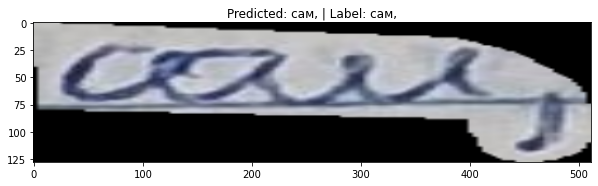

In [205]:
index = random.randint(0, len(batch_inputs)-1)
image = batch_inputs[index]
label = batch_labels[index]
inference = Inference(model, max_length=config.max_length, device=config.device)
outputs = inference(image.unsqueeze(dim=0))
prediction = Dataset.label2text(outputs)
label = Dataset.label2text(label)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.imshow(image.permute(1, 2, 0).to("cpu").numpy())
ax.set_title(f"Predicted: {prediction} | Label: {label}")
fig.show()